# Table of contents
1. [Introduction](#introduction)
1. [Import data](#paragraph1)
    1. [Data Dict](#subparagraph1)
    1. [Data Summary](#subparagraph2)
1. [Categorical Features](#paragraph2)
1. [Continuous Features](#paragraph3)
1. [Examining the Target](#paragraph4)
1. [Spatial Analysis](#paragraph5)
1. [Temporal Analysis](#paragraph6)
1. [Preliminary Model_Fitting](#paragraph7)



In [1]:
#pydata
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# display and visualization
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

# custom tools
import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Introduction <a name="introduction"></a>
### Exploring Data

I usually approach EDA in the following way:
1. Create a data dict which we can annotate as we go.
1. For each feature, compute summary statistics for following categories:
    1. Data Type
    1. Missingness
    1. Cardinality (number of unique values)
    1. Central Tendency
    1. Dispersion
    1. Correlation with target
1. Categorical Variables:
    1. Value Counts and Box Plots with the Target
1. Continuous Variables:
    1. Univariate plots (I like stripplots)
    1. Bivariate plots (I like scattermatrices with groups of variables)
    1. Correlation among continuous features (correlation matrix clustermap)
1. Geographic Analysis (if applicable)
    1. Maps, colored by categorical and continuous features
1. Temporal Analysis (if applicable)
    1. Line plots where `time` is on the x-axis



### Load data

In [3]:
# `pd.read_html()`  requires packages: lxml, html5lib, beautifulsoup4
data_dict = (pd.read_html('../data/AttributeDescriptions.html')[0]
             .copy()
             .rename(columns=lambda x: x.lower().replace(" ", "_"))
             .assign(field_name=lambda x: x["field_name"].apply(lambda x: x.lower()))
             .set_index("field_name")
             .sort_index()
            )

In [4]:
display(Markdown("### Data Dict"))
data_dict.head().style.set_properties(subset=['description'], **{'width': '700px'})

### Data Dict

In [5]:
# Load the dataframes
test_df = pd.read_csv('../data/cleaned-input.test.tsv', sep='\t', low_memory=False)
train_df = pd.read_csv('../data/cleaned-input.training.tsv', sep='\t', low_memory=False)

In [6]:
concat_df = pd.concat([test_df.assign(data_group="TEST"),
                       train_df.assign(data_group="TRAIN")
                      ])

In [7]:
# Specify some columns for future reference
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_col = "production_liquid_180"

## Create a dataframe for further inspection
There's actually quite a bit going on here.
I'm doing some basic data munging and feature engineering before even looking at the data.
Two main things are happening:
1. I want a per-foot calculation for many of the completion features, because that gives a true notion of "stimulation intensity"
    1. In order to do so, we need some notion of the lateral length of each well. My function needs a little bit of work, because it seems to be generating null values in many cases.
1. Another thing we can calculate relatively easily is interwell spacing.


In [94]:
inspect_df = (concat_df.copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: dmt.haversine_distance(x["surface_lat"], 
                                                                      x["surface_lng"], 
                                                                      x["bh_lat"], 
                                                                      x["bh_lng"]),
                              prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                              fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                              stage_spacing=lambda x: x["total_num_stages"] / x["length"],
                              range_tvd=lambda x: x["max_tvd"] - x["min_tvd"]
                             )
                      .pipe(dmt.find_distance_to_nearest_neighbor, *coord_cols)
             )

In [95]:
# I almost always look at the head and tail of the data first.
display(inspect_df.head(1),
        inspect_df.tail(1)
       )

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33023010680000              90.00   48.73 -103.85      28/64     DIVIDE   

                 currentoperator                 currentwellname data_group  \
api                                                                           
33023010680000  HUNT OIL COMPANY  WRITING ROCK  161-101-30-31H-1       TEST   

                dfelev     fieldname  ...  well_status_date    wellbore  \
api                                   ...                                 
33023010680000     nan  WRITING ROCK  ...        2014-02-07  HORIZONTAL   

                wellstatus  welltype  length prop_per_ft  fluid_per_ft  \
api                                                                      
33023010680000           A        OG 6164.12      438.36          9.44   

                stage_spacing  range_tvd  shortest_dist  
api                                                      
33023010680000           0.00     587.62           0.03  

[1 rows x 59 columns]

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33007016960000              40.00   47.30 -103.08      26/64   BILLINGS   

                   currentoperator             currentwellname data_group  \
api                                                                         
33007016960000  PETRO-HUNT, L.L.C.  ZABOLOTNY  144-98-3A-10-1H      TRAIN   

                dfelev     fieldname  ...  well_status_date    wellbore  \
api                                   ...                                 
33007016960000     nan  LITTLE KNIFE  ...        2012-05-30  HORIZONTAL   

                wellstatus  welltype   length prop_per_ft  fluid_per_ft  \
api                                                                       
33007016960000           A        OG 10357.79      268.25          5.98   

                stage_spacing  range_tvd  shortest_dist  
api                                                      
33007016960000           0.00     537.21           0.03  

[1 rows x 59 columns]

In [144]:
df_summary = dmt.make_df_summary(inspect_df, target_col=target_col)
# display(df_summary.head())

In [145]:
summary_df = df_summary.join(data_dict)
summary_df["using"] = np.nan
summary_df["notes"] = np.nan
# display(summary_df.head())

In [147]:
print("Feature categories already in the data dict:")
summary_df.category.value_counts(dropna=False)

Feature categories already in the data dict:


NaN                 30
Location            11
Target              10
CompletionDesign     4
Geology              3
Identifier           1
Name: category, dtype: int64

In [13]:
# Filling out the rest of the summary df

# The thing we are trying to predict
summary_df.loc[summary_df.category == 'Target', ["using"]] = False

# Location
summary_df.loc[["footages", "qq"], "category"] = "Location"
summary_df.loc[summary_df.category == 'Location', ["using"]] = False

# Depth measurements
tvd_cols = summary_df.T.filter(regex="tvd").columns.tolist()
tvd_cols.append("td")
summary_df.loc[tvd_cols, ["category", "using"]] = "Location", True
summary_df.loc["max_tvd", "using"] = False
summary_df.loc["max_tvd", "notes"] = "basically the same as `tvd`"

# Elevation measurements
elev_cols = summary_df.T.filter(regex="elev").columns.tolist()
summary_df.loc[elev_cols, ["category", "using"]] = "Location", False

# Geology
summary_df.loc['bakken_isopach_ft', "using"] = True
summary_df.loc[['producedpools', 'stimulated_formation'], "using"] = False

### Completion Design Parameters
summary_df.loc[summary_df.category == 'CompletionDesign', "notes"] = "total completion"
summary_df.loc[["length", "legs", "choke_size", "num_pools_produced"], "category"] = "CompletionDesign"
summary_df.loc[summary_df.category == 'CompletionDesign', "using"] = True
summary_df.loc[["type_treatment", "legs", "num_pools_produced"], ["using", "notes"]] = False , "no meaningful variation"
normd_cols = ["prop_per_ft", "fluid_per_ft", "shortest_dist", "stage_spacing"]
summary_df.loc[normd_cols + ["legs", "length"], "category"] = "CompletionDesign"
summary_df.loc[normd_cols, ["using", "notes"]] = True, "normd completion"
summary_df.loc["choke_size", "notes"] = "needs parsing"

# Metadata
meta_cols = ["fileno", 
             "data_group",
             "currentoperator", 
             "currentwellname", 
             "originaloperator", 
             "originalwellname", 
             "spud_date", 
             "well_status_date", 
             "wellbore", 
             "wellstatus", 
             "welltype"]

summary_df.loc[meta_cols, "category"] = "metadata"
summary_df.loc[meta_cols, "using"] = False

In [15]:
summary_df.query("using == True")

dtype num_unique perc_missing       mean        std  \
column                                                                      
total_num_stages      int64         74         0.00      25.78      10.97   
bakken_isopach_ft   float64         14         0.00      86.66      24.66   
fluid_per_ft        float64       6509        19.79      19.76     209.30   
length              float64       7703         5.08    8498.67    2843.76   
mean_tvd            float64       7703         5.08   10173.52    1129.57   
min_tvd             float64       7576         5.08    9623.74    1186.00   
prop_per_ft         float64       6630        18.30     962.71   11075.74   
range_tvd           float64       7221         5.08     635.48     295.57   
shortest_dist       float64       5272         5.08       0.01       0.01   
stage_spacing       float64       7703         5.08       0.01       0.11   
std_tvd             float64       7703         5.08     130.57      89.65   
td                  float64       3829         0.18   19446.52    2515.49   
total_lbs_proppant  float64       6858        13.33 3139137.49 4012517.07   
total_volume_bbls   float64       6606        14.82   65553.28   63878.26   
tvd                 float64       7584         5.08   10232.45    1123.33   
choke_size           object        234         9.45        nan        nan   

                   coeff_var  entropy     min        25%        50%  \
column                                                                
total_num_stages        0.43      nan    1.00      21.00      30.00   
bakken_isopach_ft       0.28      nan   10.00      70.00      90.00   
fluid_per_ft           10.59      nan    0.01       4.35       5.93   
length                  0.33      nan    3.95    6778.20    9922.72   
mean_tvd                0.11      nan 1259.81    9887.61   10474.29   
min_tvd                 0.12      nan  651.53    9308.51    9923.31   
prop_per_ft            11.50      nan    0.28     237.51     312.60   
range_tvd               0.47      nan    0.00     534.20     592.26   
shortest_dist           1.31      nan    0.00       0.00       0.01   
stage_spacing          13.03      nan    0.00       0.00       0.00   
std_tvd                 0.69      nan    0.00     100.06     118.42   
td                      0.13      nan 1860.00   19088.75   20278.50   
total_lbs_proppant      1.28      nan    0.00 2098549.00 2874347.00   
total_volume_bbls       0.97      nan    0.00   39126.75   54571.50   
tvd                     0.11      nan 1267.65    9932.52   10528.18   
choke_size               NaN     3.59     nan        nan        nan   

                          75%          max corr_target          category  \
column                                                                     
total_num_stages        31.00        98.00        0.22  CompletionDesign   
bakken_isopach_ft      100.00       140.00        0.15           Geology   
fluid_per_ft             8.44     13102.55        0.02  CompletionDesign   
length               10111.17     15759.64        0.08  CompletionDesign   
mean_tvd             10822.27     11557.49        0.17          Location   
min_tvd              10310.20     11031.20        0.16          Location   
prop_per_ft            393.24    681189.28        0.02  CompletionDesign   
range_tvd              667.24      8943.58       -0.00          Location   
shortest_dist            0.01         0.32       -0.30  CompletionDesign   
stage_spacing            0.00         7.34        0.02  CompletionDesign   
std_tvd                142.93      2763.85       -0.02          Location   
td                   20851.50     26908.00        0.15          Location   
total_lbs_proppant 3648811.00 287883716.00        0.20  CompletionDesign   
total_volume_bbls    75724.00   3069486.00        0.21  CompletionDesign   
tvd                  10880.44     11608.29        0.17          Location   
choke_size                nan          nan         NaN  Completi

 <a name="paragraph2"></a>
# Inspect Categorical Features

In [17]:
cat_df = inspect_df.copy().select_dtypes("O")

In [18]:
for col in cat_df.columns:
    nunique = cat_df[col].nunique()
    display(Markdown(f"### {col}: {nunique}"))
    display(cat_df[col].value_counts().to_frame().head(5))

### choke_size: 234

choke_size
48/64         659
24/64         643
32/64         596
28/64         428
/64           412

### countyname: 15

countyname
MCKENZIE         2229
MOUNTRAIL        1997
DUNN             1343
WILLIAMS         1336
DIVIDE            540

### currentoperator: 57

currentoperator
WHITING OIL AND GAS CORPORATION             1079
CONTINENTAL RESOURCES, INC.                  926
HESS BAKKEN INVESTMENTS II, LLC              814
EOG RESOURCES, INC.                          515
XTO ENERGY INC.                              514

### currentwellname: 8114

currentwellname
PENNINGTON  41-4H                2
CAPER  3-15-22H                  1
CAPITOL  14-7MBH                 1
MILDRED  5-19H1                  1
BREKHUS  12-14H                  1

### data_group: 2

data_group
TRAIN        6529
TEST         1586

### fieldname: 342

fieldname
SANISH              485
PARSHALL            328
ALGER               251
MURPHY CREEK        168
SIVERSTON           158

### footages: 7537

footages
250 FNL  1320 FWL        14
300 FSL  1320 FEL        13
300 FNL  1320 FEL        13
500 FNL  500 FWL         10
300 FNL  300 FWL          9

### leasename: 3712

leasename
FORT BERTHOLD        113
MHA                   86
WAYZETTA              58
AUSTIN                47
PARSHALL              43

### leasenumber: 5421

leasenumber
1-H             84
1               31
1-22H           24
1-29H           23
1H              21

### originaloperator: 102

originaloperator
CONTINENTAL RESOURCES, INC.                   889
WHITING OIL AND GAS CORPORATION               746
HESS CORPORATION                              676
EOG RESOURCES, INC.                           516
MARATHON OIL COMPANY                          441

### originalwellname: 8108

originalwellname
HANSEN  21-3H                                        2
STATE OF NORTH DAKOTA  154-99-16A-5H                 2
P WOOD  154-98-3-27-34-14H                           2
BAKER  29-31H                                        2
ANGUS  2-9H                                          2

### producedpools: 15

producedpools
BAKKEN                       7845
SANISH                        102
SPEARFISH                      88
BAKKEN/THREE FORKS             37
MADISON                        10

### qq: 47

qq
SWSE  1136
SESE   927
SESW   926
NENW   791
NWNW   747

### range: 25

range
95 W    935
92 W    811
96 W    733
99 W    710
93 W    703

### spud_date: 2258

spud_date
2013-05-02         14
2012-10-01         14
2013-01-15         14
2013-06-18         13
2014-01-11         12

### stimulated_formation: 15

stimulated_formation
bakken                       4951
three forks                  2016
spearfish                     104
pronghorn                      10
madison                         5

### township: 30

township
152 N       824
153 N       728
154 N       682
151 N       652
155 N       652

### type_treatment: 9

type_treatment
sand frac                     5729
other                          797
fracture                       184
other,sand frac                  3
fracture,sand frac               3

### well_status_date: 2286

well_status_date
2013-04-18                15
2012-12-14                15
2012-06-26                14
2014-06-24                14
2014-07-29                14

### wellbore: 3

wellbore
HORIZONTAL               8104
HORIZONTAL RE-ENTRY         6
DIRECTIONAL                 5

### wellstatus: 8

wellstatus
A          7773
IA          305
TA           10
PA            8
DRL           7

### welltype: 1

welltype
OG      8115

## Categorical Plots

In [19]:
cat_df = (inspect_df.copy()
                  .select_dtypes("O")
                  .pipe(dmt.drop_hi_lo_card)
                  .pipe(dmt.reduce_cardinality)
         )

cat_cols = cat_df.columns

cat_df = cat_df.join(inspect_df.filter([target_col]))

Shape before cardinality removal: (8115, 22)
Shape after cardinality removal: (8115, 14)


In [20]:
print("categorical features:")
cat_cols

categorical features:


Index(['choke_size', 'countyname', 'currentoperator', 'data_group',
       'fieldname', 'originaloperator', 'producedpools', 'qq', 'range',
       'stimulated_formation', 'township', 'type_treatment', 'wellbore',
       'wellstatus'],
      dtype='object')

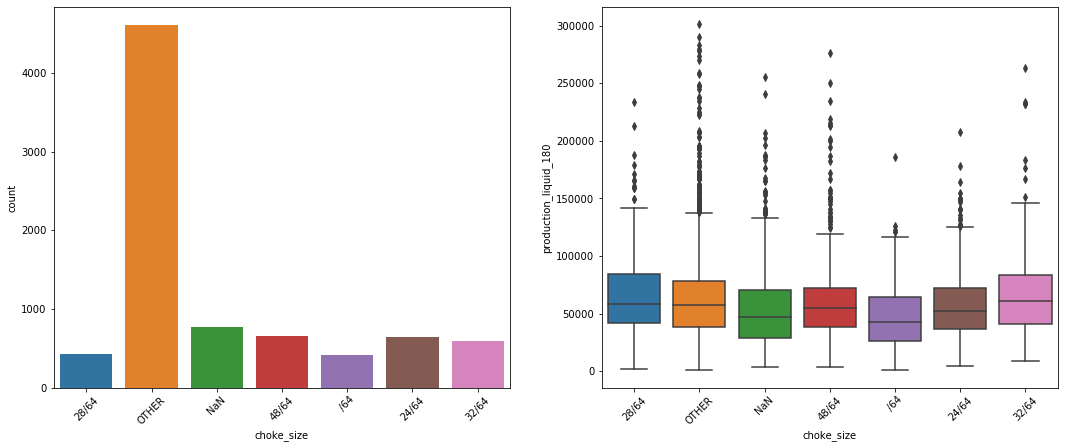

In [21]:
dmt.inspect_cat_plots(cat_df, "choke_size", target_col)

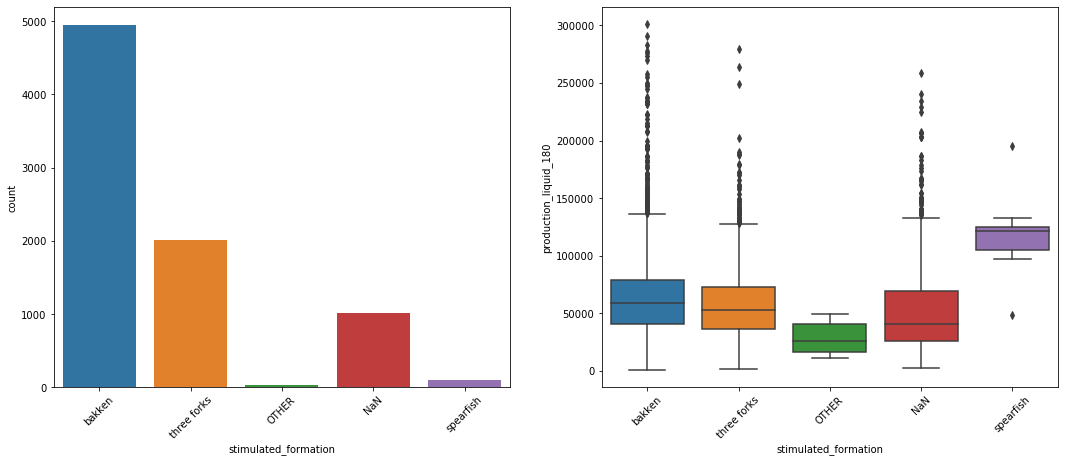

In [22]:
dmt.inspect_cat_plots(cat_df, "stimulated_formation", target_col)

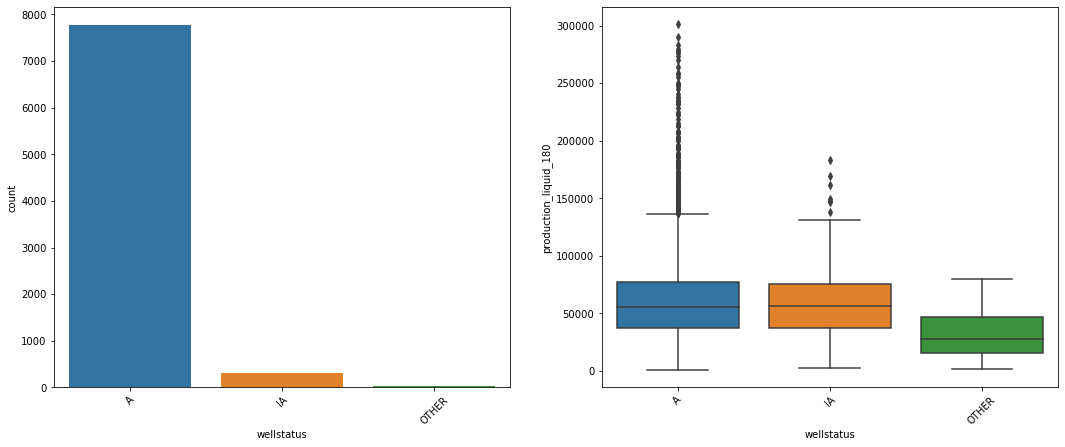

In [23]:
dmt.inspect_cat_plots(cat_df, "wellstatus", target_col)

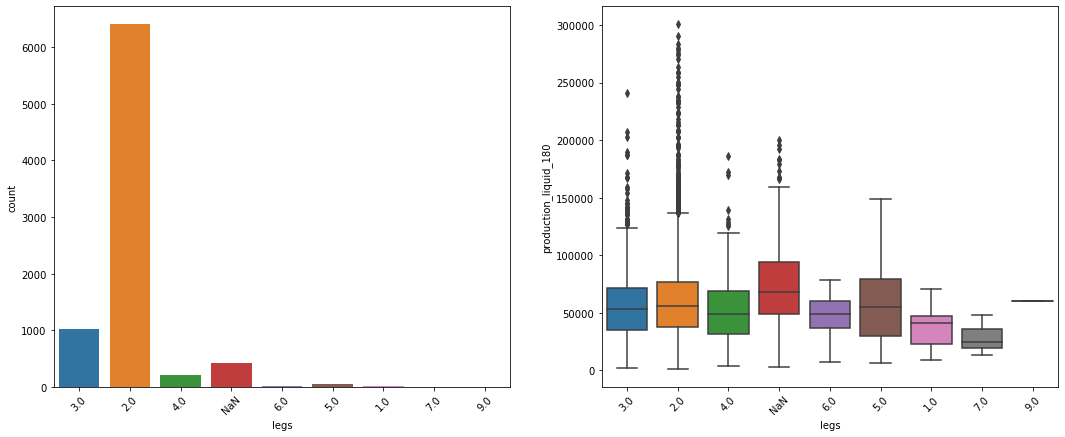

In [152]:
dmt.inspect_cat_plots(inspect_df, "legs", target_col)

### Conclusion: theres nothing really useful here, except maybe choke size

# Inspect Continuous Features  <a name="paragraph3"></a>

In [150]:
foi = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
'legs',
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing', 
'mean_tvd',
'bakken_isopach_ft',
'choke_size',
'shortest_dist',
target_col
])

total_cols = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
target_col
])

normd_cols = sorted([
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing',
target_col
])

other = sorted([
'mean_tvd',
'bakken_isopach_ft' 
])

In [151]:
cont_df = (inspect_df.copy()
                   .assign(choke_size=lambda x: x["choke_size"].apply(lambda x: dmt.parse_choke_size(x)))
                   .select_dtypes("number")
                   .filter(foi)
                   .sort_index(axis=1)
          )

In [26]:
cont_df.shape

(8115, 13)

In [27]:
cont_df.columns

Index(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs', 'length',
       'mean_tvd', 'production_liquid_180', 'prop_per_ft', 'shortest_dist',
       'stage_spacing', 'total_lbs_proppant', 'total_num_stages',
       'total_volume_bbls'],
      dtype='object')

## Setting outliers to NaN

In [28]:
thresh_dict = defaultdict(lambda: {"min": 0, "max": float("inf")})
thresh_dict["total_lbs_proppant"]["max"] = 20000000.0
thresh_dict["total_volume_bbls"]["max"] = 500000.0
thresh_dict["length"]["min"] = 2000
thresh_dict["mean_tvd"]["min"] = 4000
thresh_dict["total_num_stages"]["min"] = 5

In [29]:
cont_df.head()

bakken_isopach_ft  choke_size  fluid_per_ft  legs   length  \
api                                                                          
33023010680000              90.00        0.44          9.44  3.00  6164.12   
33061019000000             110.00        1.00          2.97  2.00  9150.57   
33053051430000              80.00        0.28          1.62  2.00  9926.80   
33053045070000              80.00        0.34          4.69  2.00 10054.43   
33053047660000              90.00        0.61         34.53  3.00  2785.10   

                mean_tvd  production_liquid_180  prop_per_ft  shortest_dist  \
api                                                                           
33023010680000   8682.48               25694.00       438.36           0.03   
33061019000000   9827.68               45299.00       204.01           0.00   
33053051430000  10980.10               12653.00       166.36           0.00   
33053045070000  11024.49               79246.00       648.03           0.01   
33053047660000  11109.07               74794.00      1526.69           0.01   

                stage_spacing  total_lbs_proppant  total_num_stages  \
api                                                                   
33023010680000           0.00          2702100.00                25   
33061019000000           0.00          1866840.00                26   
33053051430000           0.00          1651440.00                32   
33053045070000           0.00          6515590.00                23   
33053047660000           0.01          4251992.00                33   

                total_volume_bbls  
api                                
33023010680000           58176.00  
33061019000000           27187.00  
33053051430000           16129.00  
33053045070000           47161.00  
33053047660000           96171.00

In [30]:
cont_df.shape

(8115, 13)

In [31]:
num_missing = inspect_df[foi + coord_cols].isnull().sum(axis=1).sort_values(ascending=False)

In [32]:
num_missing.head()

api
33089005680000    13
33053060140000    13
33053059140000    12
33053059160000    12
33061029950000    11
dtype: int64

{'min': 0, 'max': 500000.0}
1207


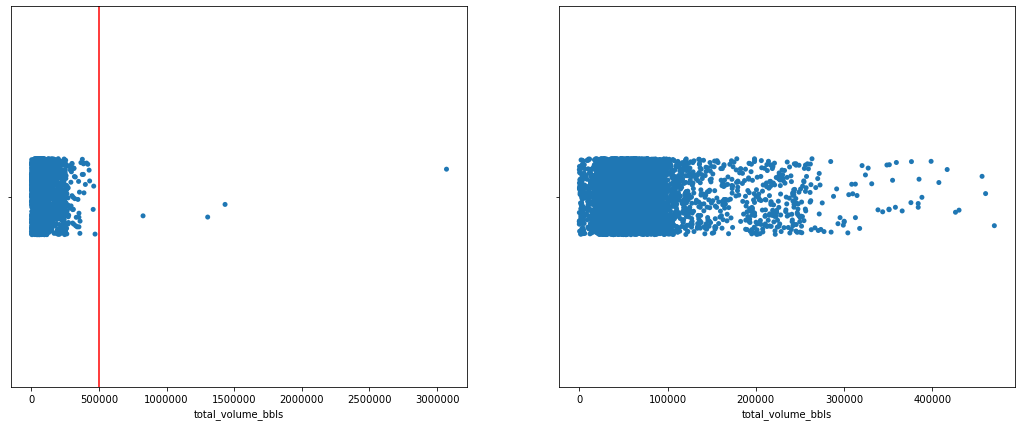

In [33]:
dmt.make_strip_plots(cont_df, "total_volume_bbls", thresh_dict)

{'min': 4000, 'max': inf}
501


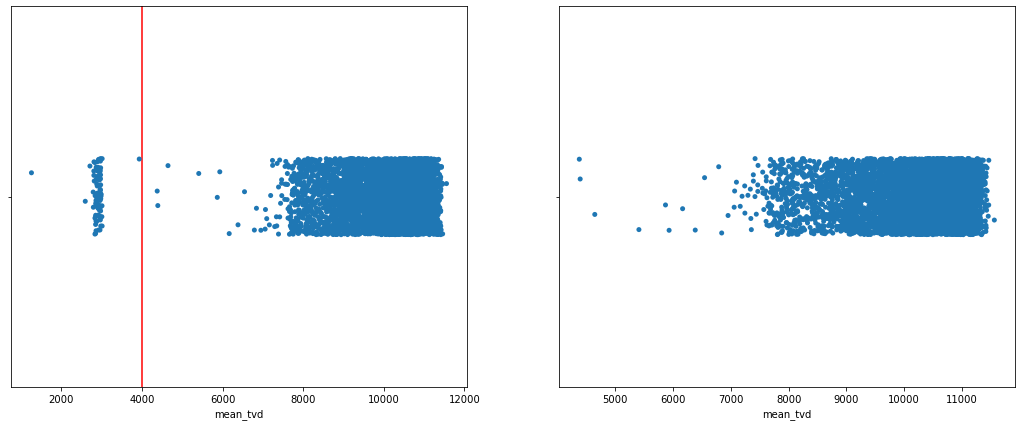

In [34]:
dmt.make_strip_plots(cont_df, "mean_tvd", thresh_dict)

{'min': 5, 'max': inf}
747


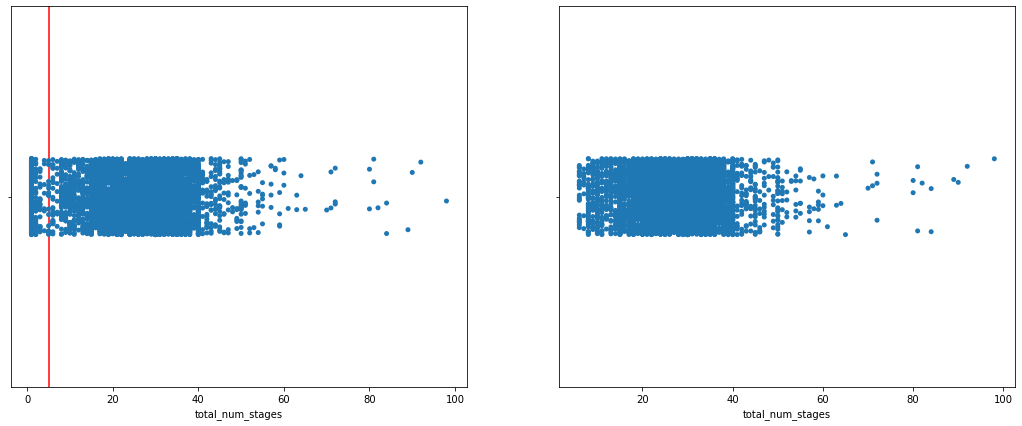

In [35]:
dmt.make_strip_plots(cont_df, "total_num_stages", thresh_dict)

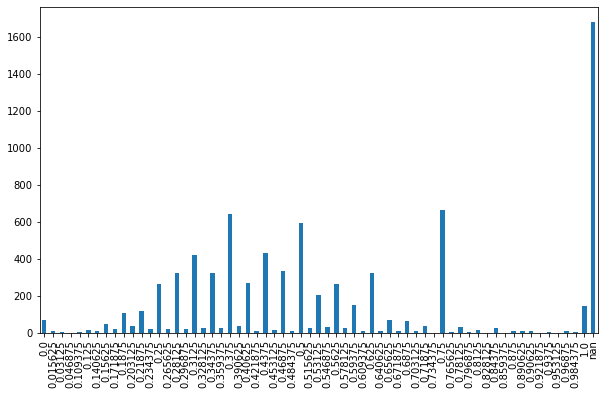

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
cont_df.choke_size.value_counts(dropna=False).sort_index().plot.bar()

### Examining Target

In [37]:
display(Markdown("### 224 wells in the training set are missing target values at IP 180"))
inspect_df.query(f"{target_col} != {target_col}").shape

### 224 wells in the training set are missing target values at IP 180

(278, 59)

In [38]:
display(Markdown("### 54 wells in the test set are missing target values at IP 180"))
test_df.query(f"{target_col} != {target_col}").shape

### 54 wells in the test set are missing target values at IP 180

(54, 53)

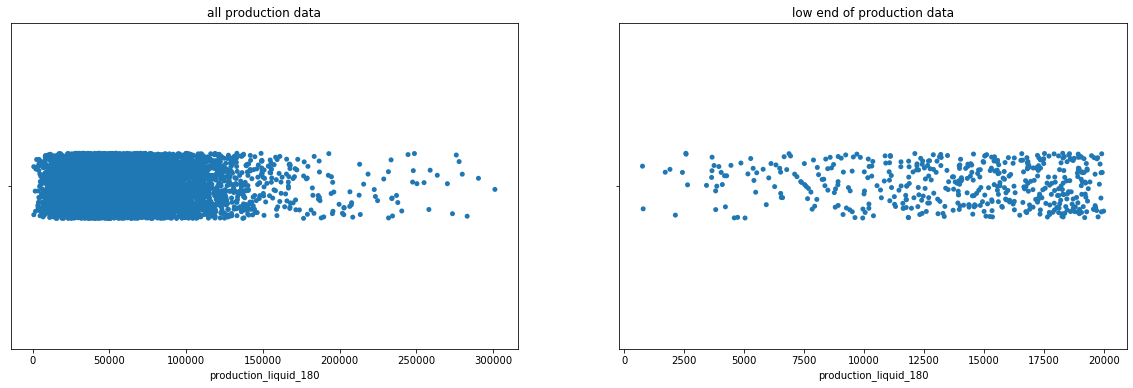

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.stripplot(inspect_df[target_col], ax=ax[0])
sns.stripplot(inspect_df.query(f"{target_col} < 20000")[target_col], ax=ax[1])
ax[0].set_title("all production data")
ax[1].set_title("low end of production data")
plt.show()

### Comparing Depth Measurements

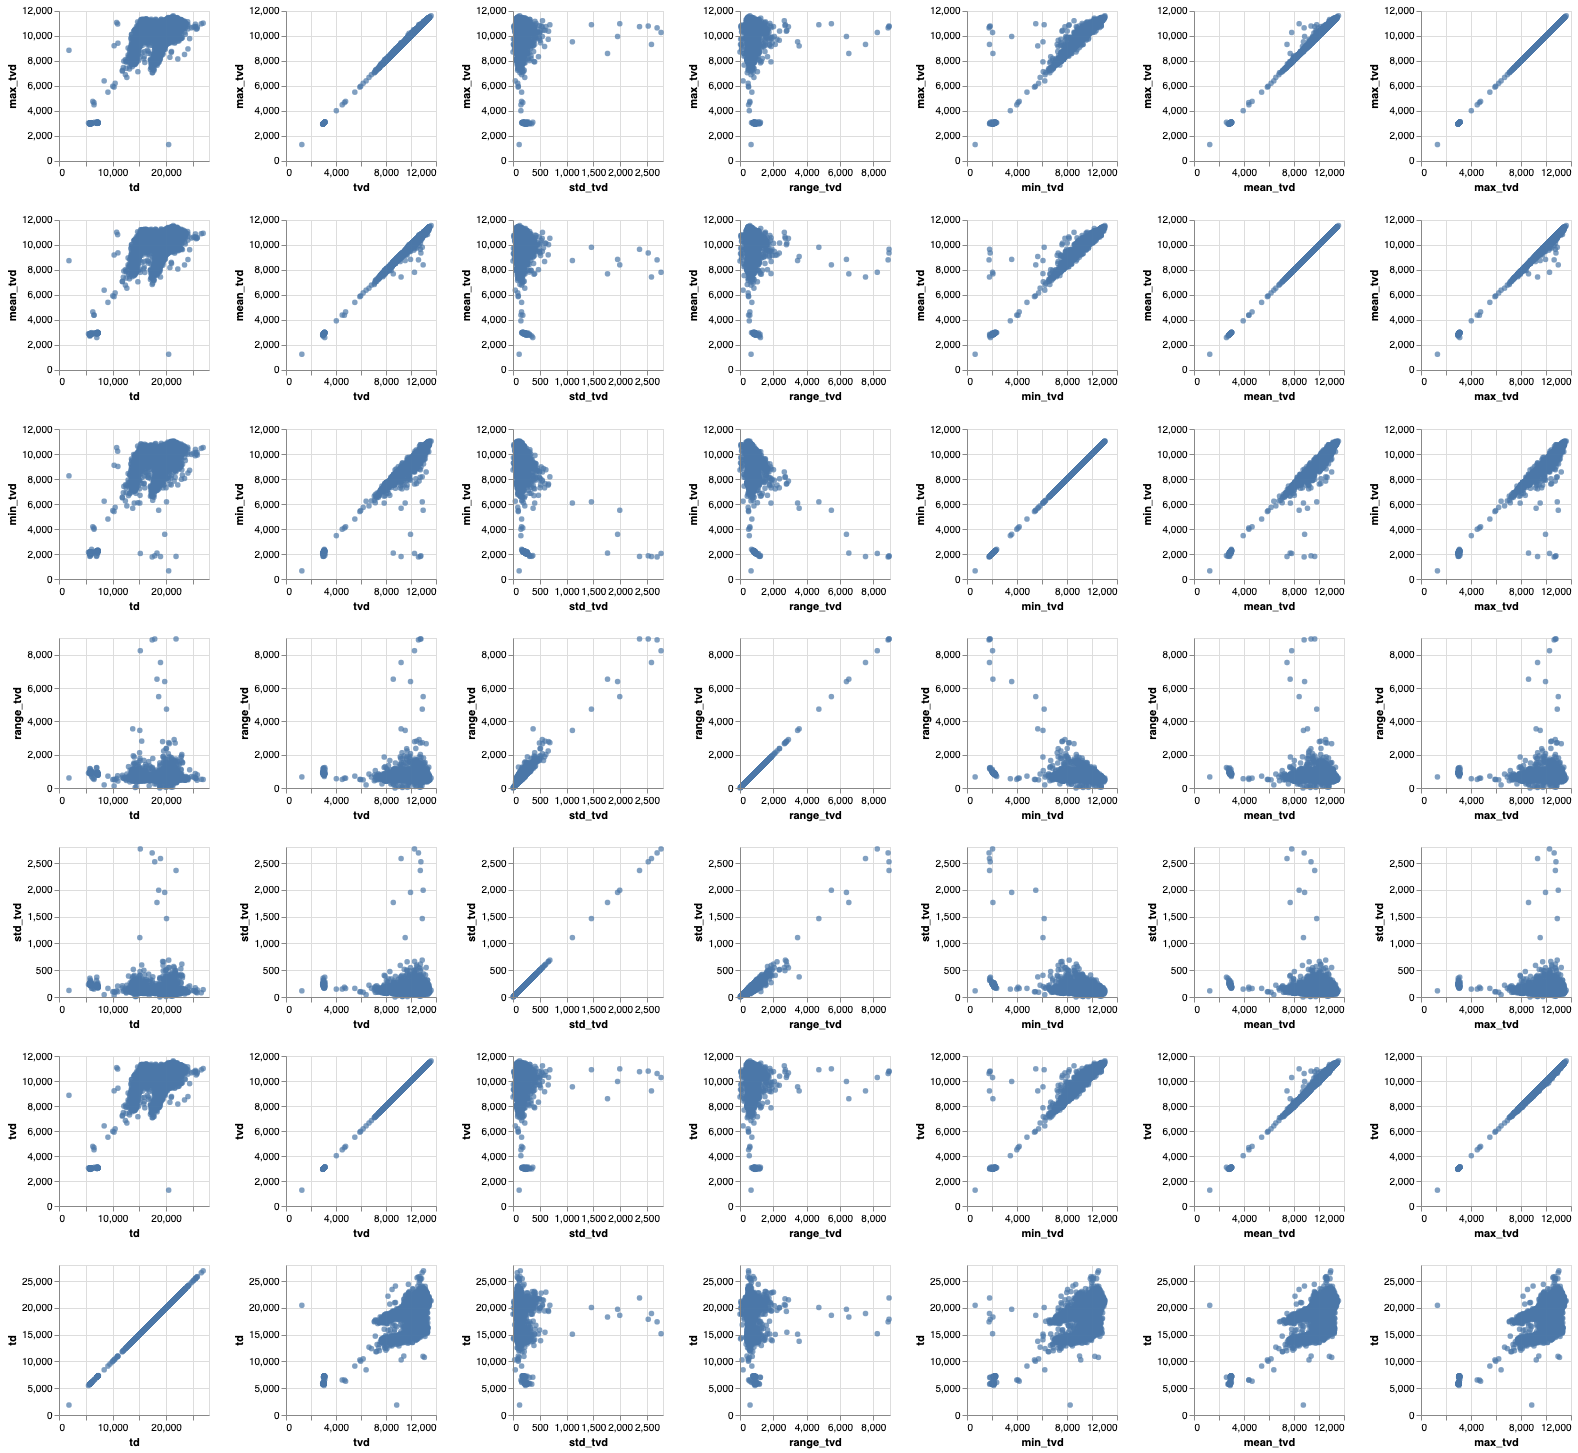

In [93]:
display(Markdown("### Comparing Depth Measurements"))
alt.Chart(inspect_df[tvd_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    row=tvd_cols,
    column=tvd_cols[::-1]
)

In [42]:
clean_df = (inspect_df.copy()
                    .assign(choke_size= lambda x: x["choke_size"].apply(dmt.parse_choke_size))
                    .pipe(dmt.remove_outiers, thresh_dict)
                    .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                            fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                            stage_spacing=lambda x: x["total_num_stages"] / x["length"]
                            )
           )

total_lbs_proppant
total_volume_bbls
length
mean_tvd
total_num_stages


### Comparing Total Measurements (After scrubbing outliers)

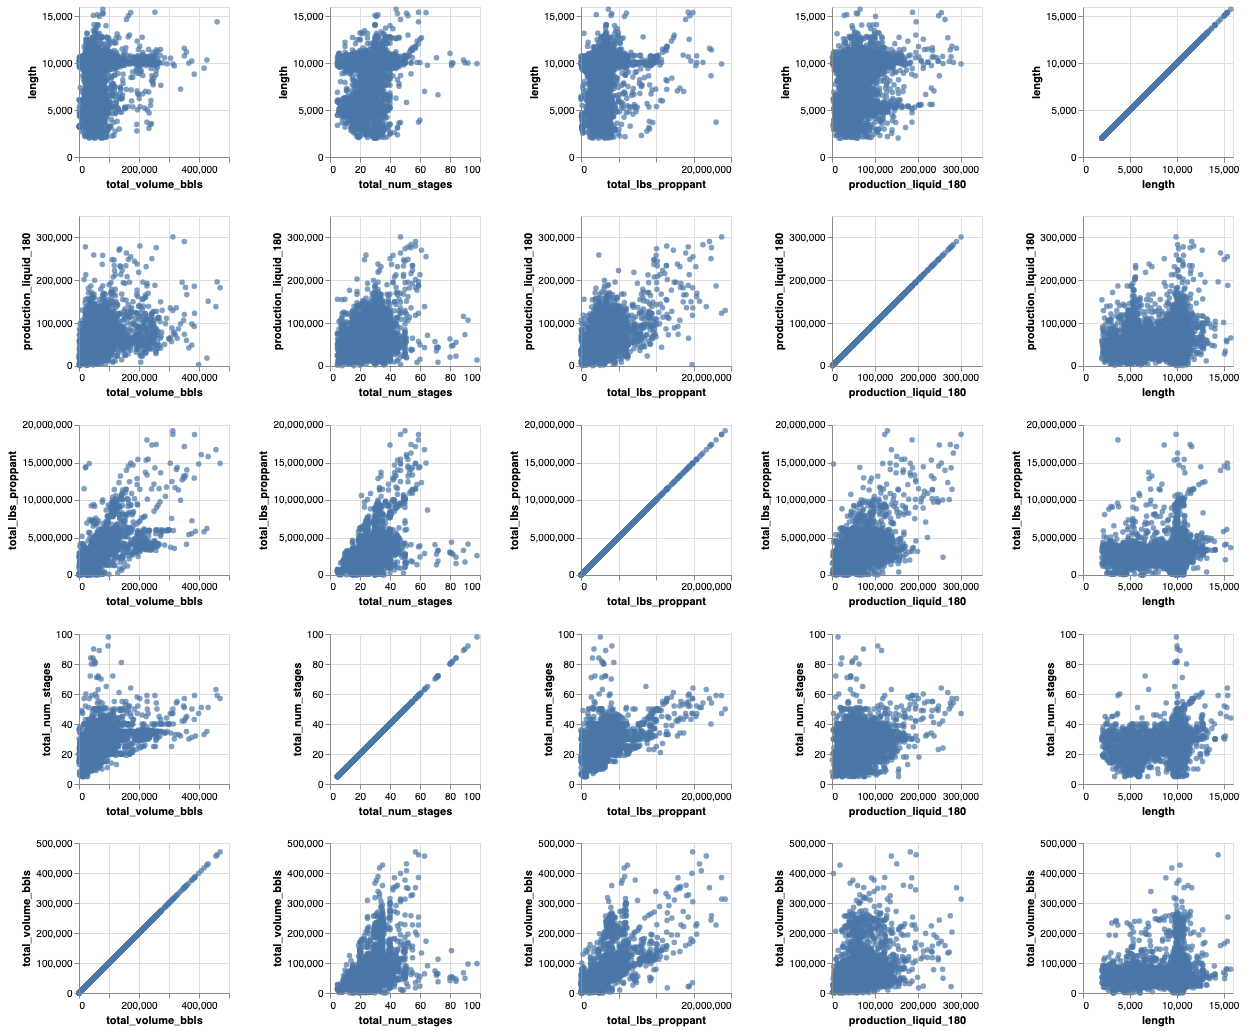

In [43]:
display(Markdown("### Comparing Total Measurements (After scrubbing outliers)"))
alt.Chart(clean_df[total_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    row=total_cols,
    column=total_cols[::-1]
)

### Comparing Normalized Measurements (After scrubbing outliers)

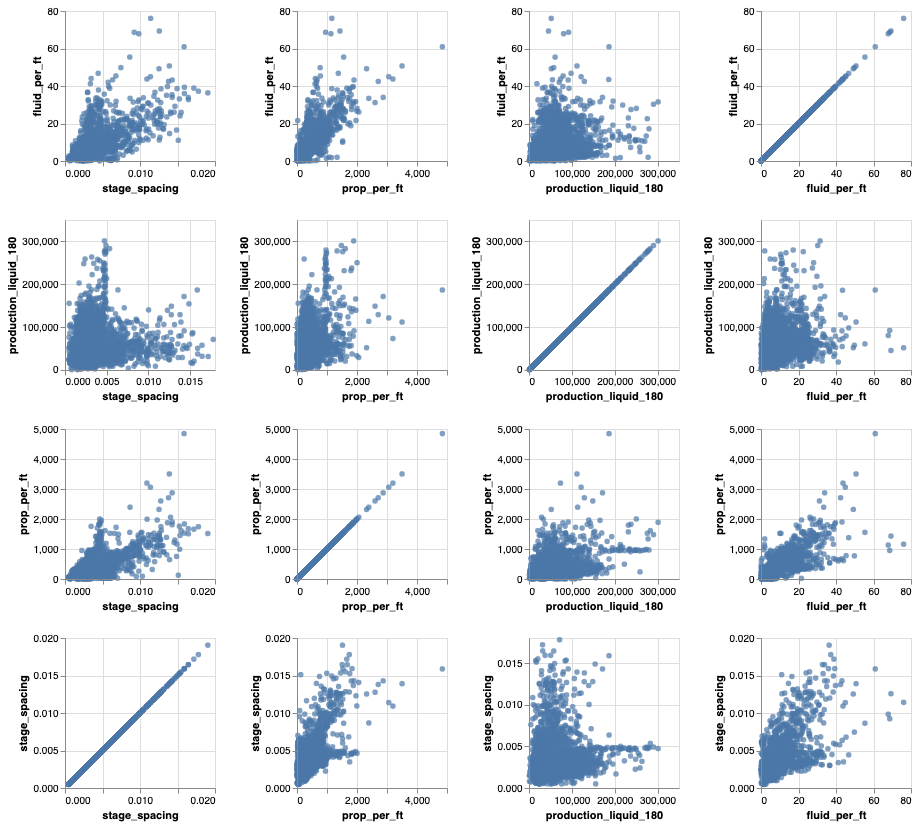

In [ ]:
display(Markdown("### Comparing Normalized Measurements (After scrubbing outliers)"))
alt.Chart(clean_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=normd_cols,
    column=normd_cols[::-1]
)

### Correlation Matrix Heatmap, with Hierarchical Clustering

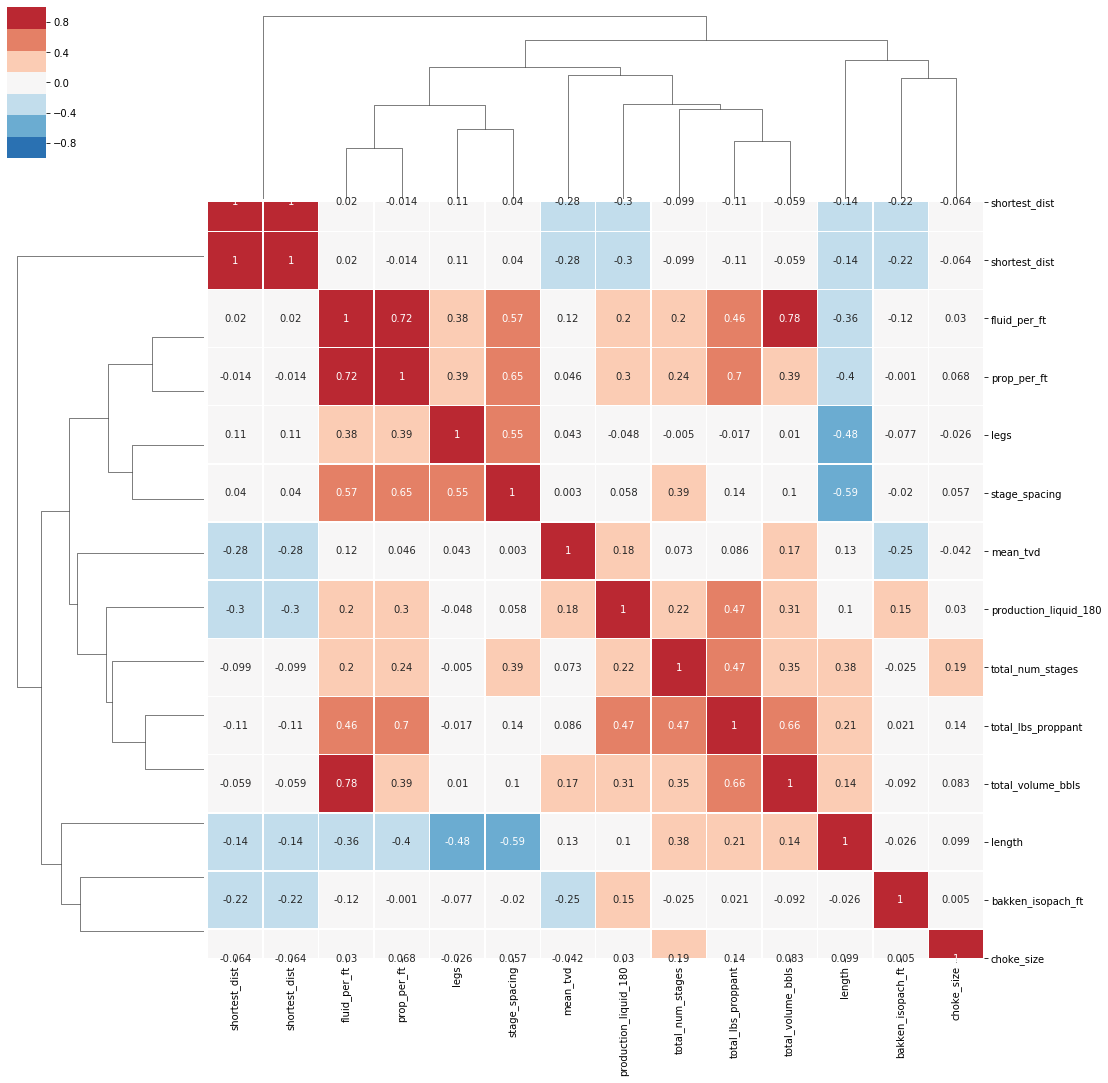

In [96]:
corr_df = clean_df.filter(foi + ["shortest_dist"]).corr().round(3)

display(Markdown("### Correlation Matrix Heatmap, with Hierarchical Clustering"))
sns.clustermap(data=corr_df, 
                    cmap=sns.color_palette("RdBu_r", 7), 
                    linewidths=.5, 
                    vmin=-1, vmax=1, 
                    annot=True)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.75)  # scale current size by 1.5

<a name="paragraph5"></a>
# Maps

In [97]:
map_df = (inspect_df.copy()
                      .filter(["surface_lng", "surface_lat", "mean_tvd", target_col, "stimulated_formation", "township", "countyname"])
                      .assign(township = lambda x: x["township"].dropna().apply(lambda x: int(x.split(" ")[0])))
                      .join(cat_df, lsuffix="_orig")
         )

### Where are highest producing wells?

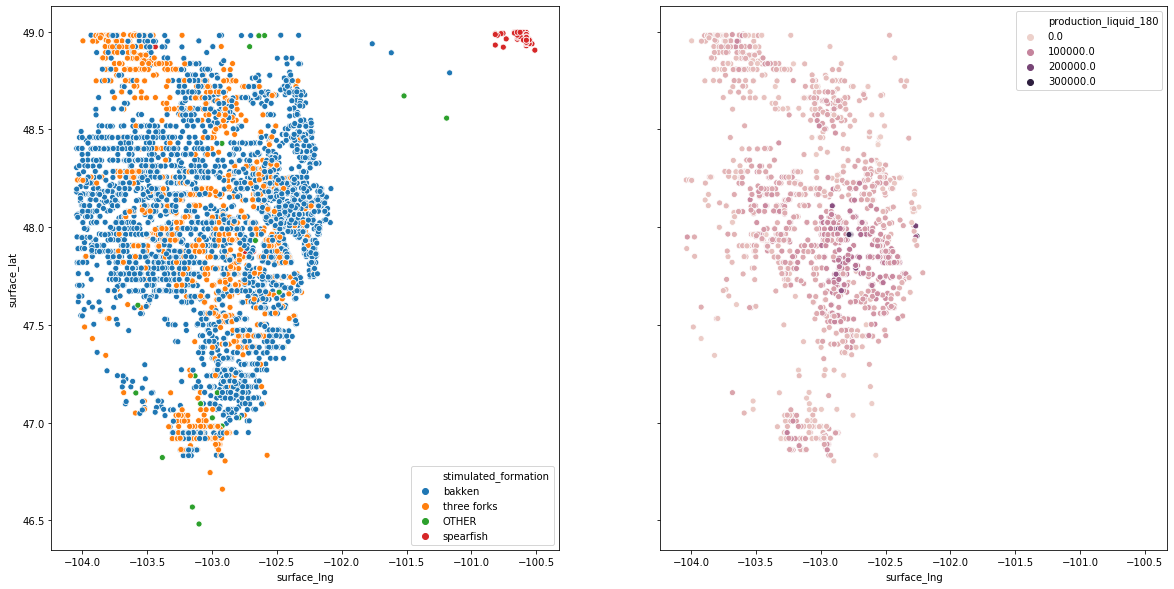

In [98]:
display(Markdown("### Where are highest producing wells?"))
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="stimulated_formation", ax=ax[0])
sns.scatterplot(data=map_df.query("stimulated_formation == 'three forks'"), x="surface_lng", y="surface_lat", hue=target_col, ax=ax[1])
plt.show()

### Political Geography: County and Township

township is basically just degrees latitude


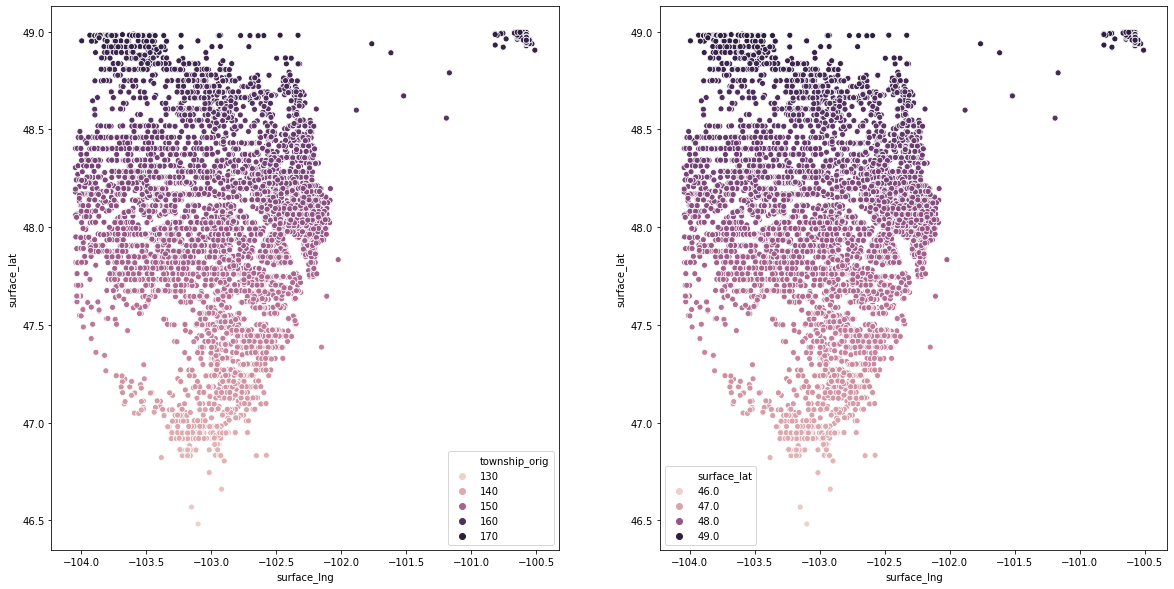

In [99]:
print("township is basically just degrees latitude")
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="township_orig", ax=ax[0])
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="surface_lat", ax=ax[1])

plt.show()

County is also just an administrative division, not a meaningful proxy for underlying geology.


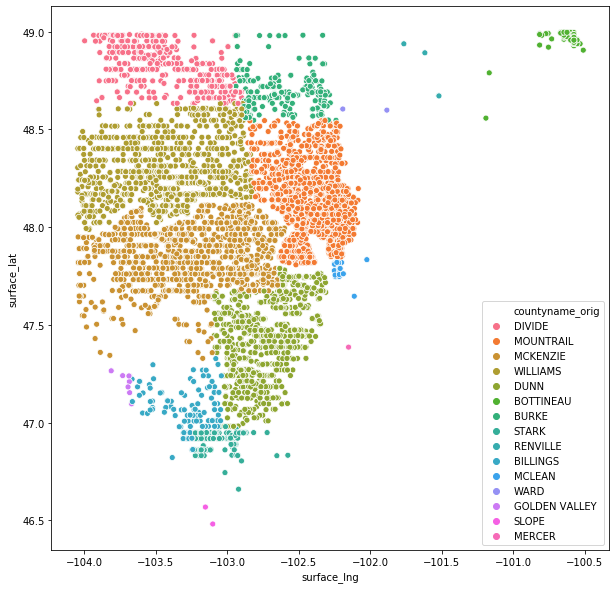

In [100]:
print("County is also just an administrative division, not a meaningful proxy for underlying geology.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="countyname_orig")
plt.show()

### Target Formation and TVD

There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.


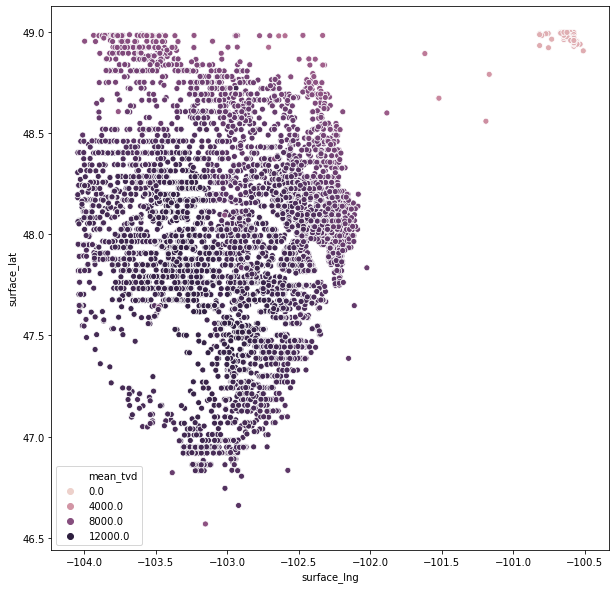

In [101]:
print("There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="mean_tvd")
plt.show()

Value Counts of Target Formation

bakken         4951
three forks    2016
NaN            1013
spearfish       104
OTHER            31
Name: stimulated_formation, dtype: int64

### Well Map, Colored and Faceted by Target Formation

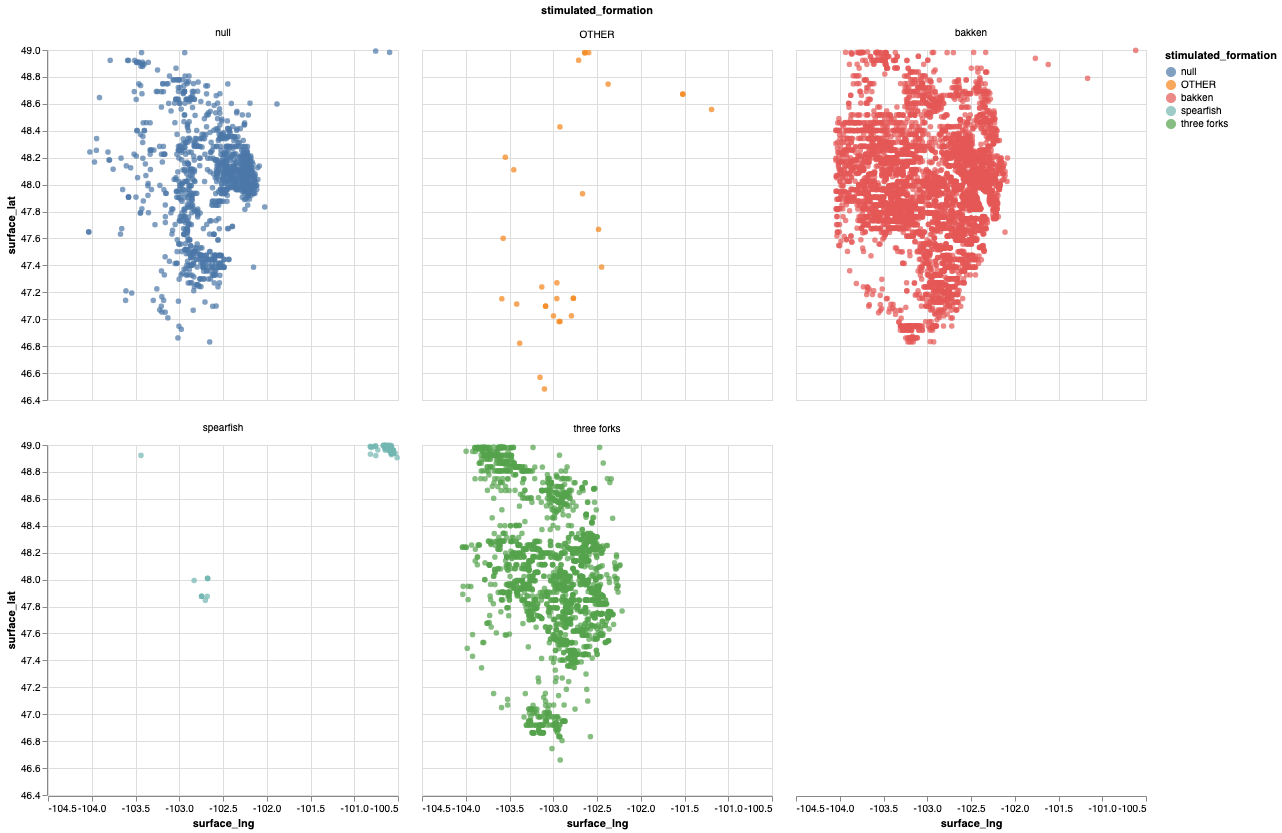

In [102]:
display(Markdown("Value Counts of Target Formation"),
        map_df.stimulated_formation.value_counts(dropna=False),
Markdown("### Well Map, Colored and Faceted by Target Formation"))
alt.Chart(map_df).mark_circle().encode(
    alt.X('surface_lng:Q',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('surface_lat:Q',
        scale=alt.Scale(zero=False)
    ),
    color='stimulated_formation:N',
#     column='stimulated_formation:N'
).properties(
    width=350,
    height=350
).facet(
    facet='stimulated_formation:N',
    columns=3
)

In [103]:
print("All of those wells in the NE corner have no production data.")
inspect_df.query("surface_lng > -101.5").filter(regex="production").notnull().sum()

All of those wells in the NE corner have no production data.


production_liquid_120     0
production_liquid_150     0
production_liquid_180     0
production_liquid_1825    0
production_liquid_270     0
production_liquid_30      0
production_liquid_365     0
production_liquid_60      0
production_liquid_730     0
production_liquid_90      0
dtype: int64

In [104]:
print("Spearfish wells NOT in the NE corner DO HAVE production data.")
inspect_df.query("surface_lng < -101.5 & stimulated_formation == 'spearfish'").filter(regex="production").notnull().sum()

Spearfish wells NOT in the NE corner DO HAVE production data.


production_liquid_120     10
production_liquid_150     10
production_liquid_180     10
production_liquid_1825     0
production_liquid_270      6
production_liquid_30      10
production_liquid_365      5
production_liquid_60      10
production_liquid_730      1
production_liquid_90      10
dtype: int64

In [105]:
total_formation_vc = (inspect_df.copy()
                      .filter(["stimulated_formation"])
                      .squeeze()
                      .value_counts(dropna=False)
                      .sort_index()
                      .to_frame()
                      .reset_index()
                      .rename(columns={"index": "stimulated_formation", "stimulated_formation": "total_count"})
                     )

missing_target_formation_vc = (inspect_df.copy()
                               .query(f"{target_col} != {target_col}")
                               .filter(["stimulated_formation"])
                               .squeeze()
                               .value_counts(dropna=False)
                               .sort_index()
                              .reset_index()
                              .rename(columns={"index": "stimulated_formation", "stimulated_formation": "missing_target_count"})
                               )


explore_vc = total_formation_vc.merge(missing_target_formation_vc, on="stimulated_formation")



Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?


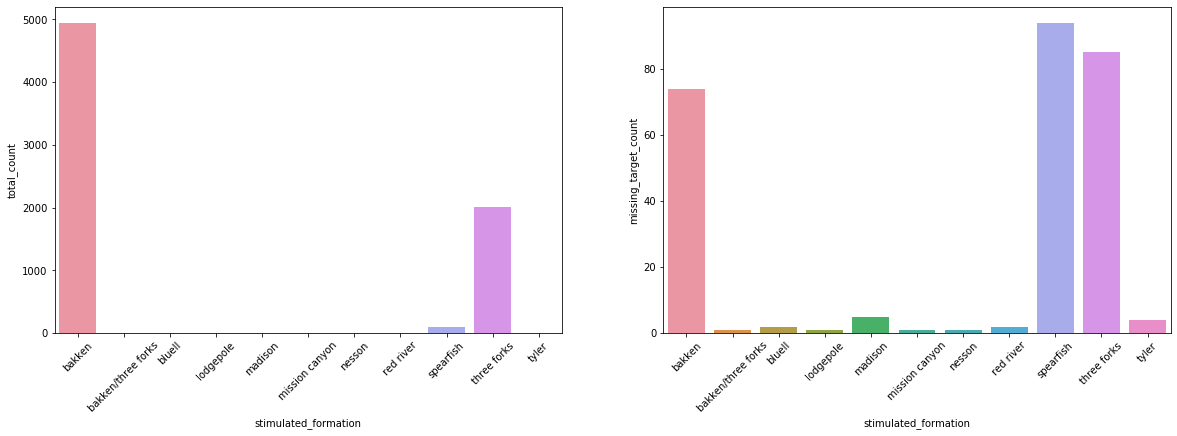

In [106]:
print("Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?")
fig, ax  = plt.subplots(1,2, figsize=(20,6))
sns.barplot(data=explore_vc, x="stimulated_formation", y="total_count", ax=ax[0])
sns.barplot(data=explore_vc, x="stimulated_formation", y="missing_target_count", ax=ax[1])
for item in ax[0].get_xticklabels() + ax[1].get_xticklabels():
        item.set_rotation(45)

### 90% of Spearfish wells are missing, including all of those in the NE corner

In [107]:
spearfish_df = inspect_df.query("stimulated_formation == 'spearfish'")

### These are not just young wells. Still 90% missing at day 30.

In [109]:
display((spearfish_df.filter(regex="production_liquid").isnull().sum() / spearfish_df.shape[0] * 100).to_frame())

0
production_liquid_120   90.38
production_liquid_150   90.38
production_liquid_180   90.38
production_liquid_1825 100.00
production_liquid_270   94.23
production_liquid_30    90.38
production_liquid_365   95.19
production_liquid_60    90.38
production_liquid_730   99.04
production_liquid_90    90.38

### Visualize distance to nearest neighbor

Seems like it worked


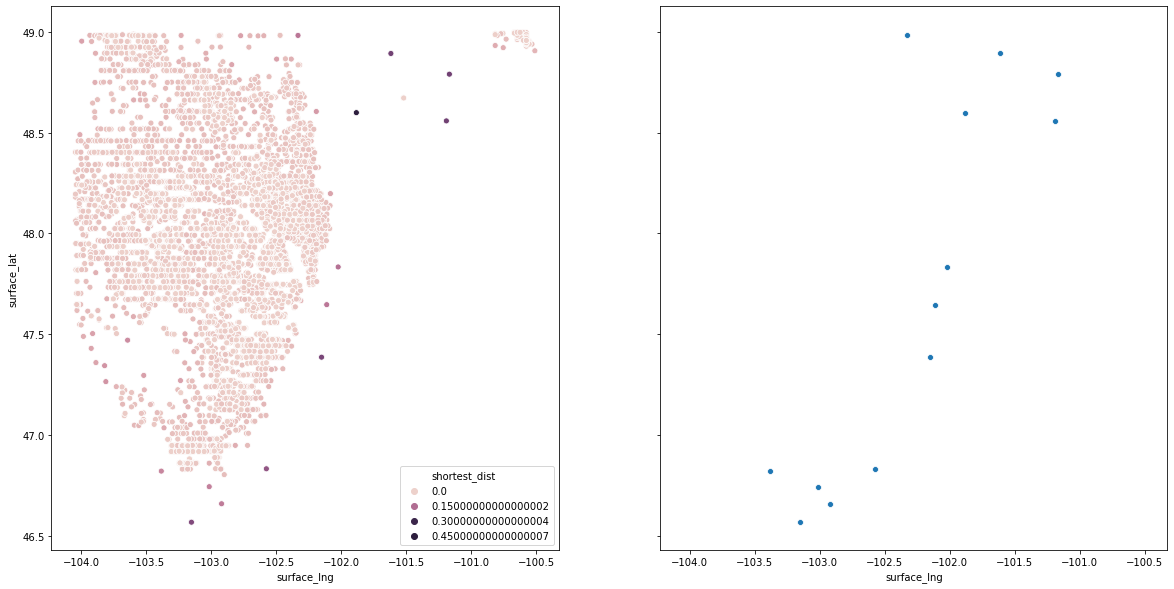

In [110]:
print("Seems like it worked")
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="shortest_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("shortest_dist > .1"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

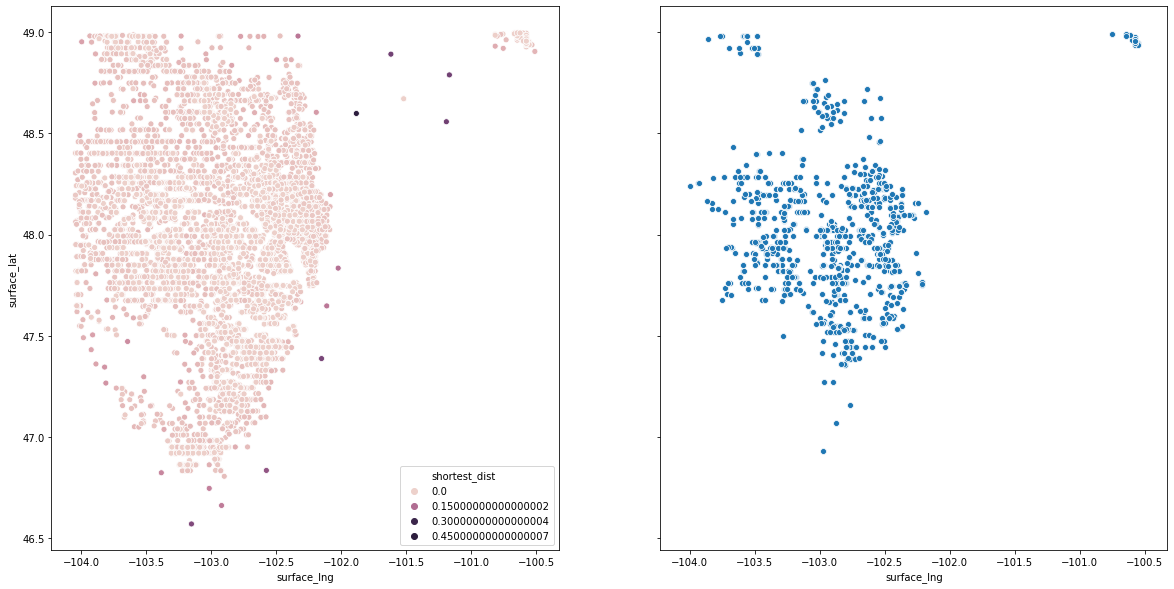

In [111]:
# The most densely spaced wells
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="shortest_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("shortest_dist < .002"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

<a name="paragraph6"></a>
# Temporal Analysis

## Frac Year

In [112]:
date_df = (inspect_df.copy()
                      .assign(spud_year=lambda x: x["spud_date"].dropna().apply(lambda x: int(x.split("-")[0])))
          )

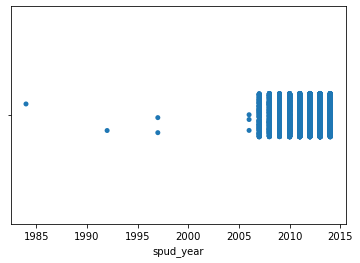

In [113]:
sns.stripplot(date_df.spud_year)

In [114]:
date_df.head()

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33023010680000              90.00   48.73 -103.85      28/64     DIVIDE   
33061019000000             110.00   48.14 -102.33      64/64  MOUNTRAIL   
33053051430000              80.00   47.67 -102.87      18/64   MCKENZIE   
33053045070000              80.00   47.70 -102.71      22/64   MCKENZIE   
33053047660000              90.00   47.72 -103.25      39/64   MCKENZIE   

                                   currentoperator  \
api                                                  
33023010680000                    HUNT OIL COMPANY   
33061019000000     WHITING OIL AND GAS CORPORATION   
33053051430000         NEWFIELD PRODUCTION COMPANY   
33053045070000  ENERPLUS RESOURCES USA CORPORATION   
33053047660000     WHITING OIL AND GAS CORPORATION   

                                 currentwellname data_group  dfelev  \
api                                                                   
33023010680000    WRITING ROCK  161-101-30-31H-1       TEST     nan   
33061019000000                 JORGENSEN  11-27H       TEST     nan   
33053051430000  MOBERG FEDERAL  149-95-29-32-11H       TEST     nan   
33053045070000            CIRRUS  149-94-33D-28H       TEST     nan   
33053047660000               SMOKEY  3-17-20-14H       TEST     nan   

                   fieldname  ...    wellbore wellstatus  welltype   length  \
api                           ...                                             
33023010680000  WRITING ROCK  ...  HORIZONTAL          A        OG  6164.12   
33061019000000        SANISH  ...  HORIZONTAL          A        OG  9150.57   
33053051430000      BEAR DEN  ...  HORIZONTAL          A        OG  9926.80   
33053045070000    EAGLE NEST  ...  HORIZONTAL          A        OG 10054.43   
33053047660000      PEMBROKE  ...  HORIZONTAL          A        OG  2785.10   

               prop_per_ft fluid_per_ft  stage_spacing  range_tvd  \
api                                                                 
33023010680000      438.36         9.44           0.00     587.62   
33061019000000      204.01         2.97           0.00     613.44   
33053051430000      166.36         1.62           0.00     556.98   
33053045070000      648.03         4.69           0.00     630.82   
33053047660000     1526.69        34.53           0.01     547.30   

                shortest_dist  spud_year  
api                                       
33023010680000           0.03    2013.00  
33061019000000           0.00    2011.00  
33053051430000           0.00    2013.00  
33053045070000           0.01    2012.00  
33053047660000           0.01    2013.00  

[5 rows x 60 columns]

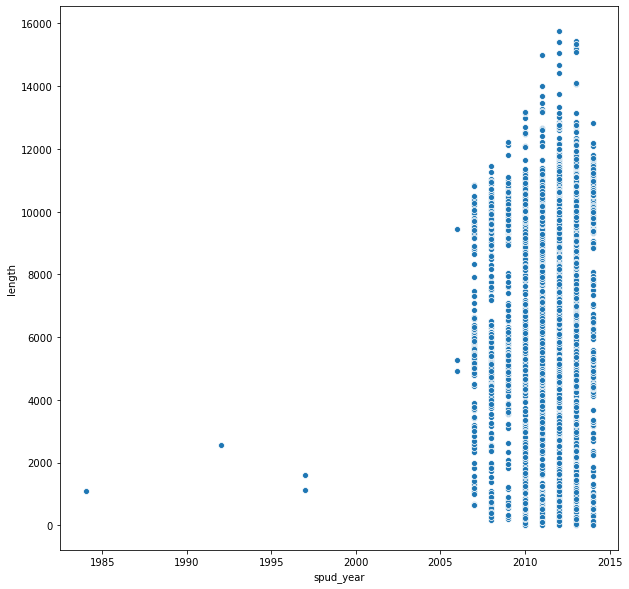

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="length", x="spud_year")

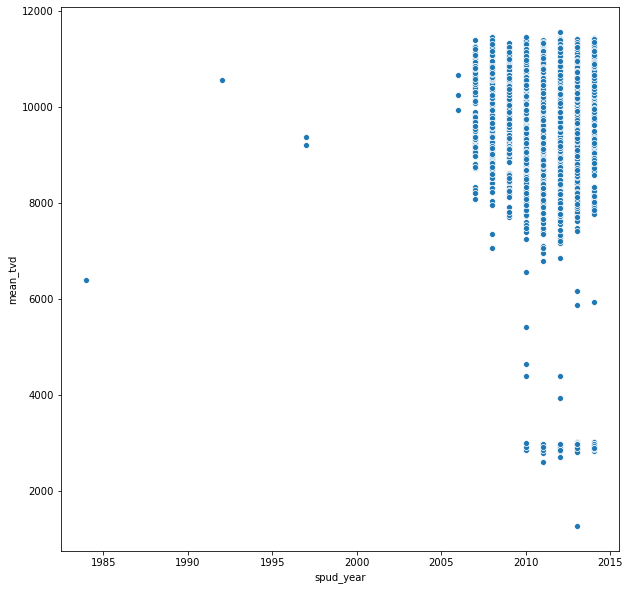

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="mean_tvd", x="spud_year")

In [117]:
date_df.query("spud_year < 2006")

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33105014330000              70.00   48.20 -103.55        /64   WILLIAMS   
33053024160000              30.00   47.46 -103.64        /64   MCKENZIE   
33013011070000              70.00   48.74 -102.37     164/64      BURKE   
33007013860000              20.00   46.82 -103.38        NaN   BILLINGS   

                                       currentoperator       currentwellname  \
api                                                                            
33105014330000                            ZAVANNA, LLC        JEFFREY  33-33   
33053024160000                        EMERALD OIL, INC      FEDERAL  21-14HR   
33013011070000  PETRO HARVESTER OPERATING COMPANY, LLC          OPSETH  29-1   
33007013860000                    DENBURY ONSHORE, LLC  SOUTH FRYBURG  40-26   

               data_group  dfelev       fieldname  ...             wellbore  \
api                                                ...                        
33105014330000       TEST     nan       WILLISTON  ...           HORIZONTAL   
33053024160000      TRAIN     nan  FLAT TOP BUTTE  ...  HORIZONTAL RE-ENTRY   
33013011070000      TRAIN     nan    SOUTH COTEAU  ...  HORIZONTAL RE-ENTRY   
33007013860000      TRAIN     nan         FRYBURG  ...  HORIZONTAL RE-ENTRY   

               wellstatus  welltype  length prop_per_ft fluid_per_ft  \
api                                                                    
33105014330000         AB        OG 1611.36         nan         0.01   
33053024160000          A        OG 2563.09      403.54        11.26   
33013011070000          A        OG 1085.17         nan         0.18   
33007013860000          A        OG 1110.99       47.67         2.78   

                stage_spacing  range_tvd  shortest_dist  spud_year  
api                                                                 
33105014330000           0.00     418.68           0.01    1997.00  
33053024160000           0.01     508.18           0.10    1992.00  
33013011070000           0.00     186.11           0.01    1984.00  
33007013860000           0.00     122.54           0.11    1997.00  

[4 rows x 60 columns]

In [118]:
date_df.query("wellbore in ['HORIZONTAL RE-ENTRY', 'DIRECTIONAL']").filter(["wellbore", "spud_date", "length", "stimulated_formation"]).sort_values("wellbore")

wellbore   spud_date  length stimulated_formation
api                                                                         
33061011940000          DIRECTIONAL  2010-02-04     nan          three forks
33007015830000          DIRECTIONAL  2010-04-10     nan              madison
33089005680000          DIRECTIONAL  2007-04-07     nan                  NaN
33025013510000          DIRECTIONAL  2011-05-28     nan            red river
33053043750000          DIRECTIONAL  2012-09-28     nan            red river
33053024160000  HORIZONTAL RE-ENTRY  1992-11-27 2563.09               bakken
33013011070000  HORIZONTAL RE-ENTRY  1984-10-30 1085.17               nesson
33023005530000  HORIZONTAL RE-ENTRY  2009-08-06 5734.45                  NaN
33101004750000  HORIZONTAL RE-ENTRY  2008-06-23 7603.19                  NaN
33007013860000  HORIZONTAL RE-ENTRY  1997-11-02 1110.99                tyler
33053027480000  HORIZONTAL RE-ENTRY  2008-01-31 2945.31                  NaN

In [119]:
date_df.query("wellbore == 'HORIZONTAL RE-ENTRY'").filter(["wellbore", "spud_date", "length", "stimulated_formation", target_col])

wellbore   spud_date  length stimulated_formation  \
api                                                                            
33053024160000  HORIZONTAL RE-ENTRY  1992-11-27 2563.09               bakken   
33013011070000  HORIZONTAL RE-ENTRY  1984-10-30 1085.17               nesson   
33023005530000  HORIZONTAL RE-ENTRY  2009-08-06 5734.45                  NaN   
33101004750000  HORIZONTAL RE-ENTRY  2008-06-23 7603.19                  NaN   
33007013860000  HORIZONTAL RE-ENTRY  1997-11-02 1110.99                tyler   
33053027480000  HORIZONTAL RE-ENTRY  2008-01-31 2945.31                  NaN   

                production_liquid_180  
api                                    
33053024160000               40223.00  
33013011070000                    nan  
33023005530000               18946.00  
33101004750000                    nan  
33007013860000                    nan  
33053027480000               21060.00

In [120]:
date_df.wellbore.value_counts()

HORIZONTAL             8104
HORIZONTAL RE-ENTRY       6
DIRECTIONAL               5
Name: wellbore, dtype: int64

## Production Data over time, for each well

In [121]:
inspect_df.query("production_liquid_90 > 0").shape

(7954, 59)

In [122]:
prod_df = (inspect_df.copy()
                   .filter(regex="production_liquid")
                   .query("production_liquid_30 > 0")
                   .rename(columns=lambda x: int(x.split("_")[-1]))
                   .drop([1825], axis=1)
                   .reset_index()
                   .melt(id_vars="api", value_name="cum_prod", var_name="ip_day")
                   .sort_values(["api", "ip_day"])
                   .reset_index(drop=True)
                   .assign(
                           ip_day=lambda x: x["ip_day"].astype(int),
                           cum_prod=lambda x: x["cum_prod"].astype(float),
                           day_diff=lambda x: x.groupby(["api"])["ip_day"].transform(pd.Series.diff),
                           prod_diff=lambda x: x.groupby(["api"])["cum_prod"].transform(pd.Series.diff),
                           prod_rate = lambda x: (x["prod_diff"] / x["day_diff"]).round(2)
                          )     
          )

In [123]:
prod_df.head()

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
0  33007015740000      30   4829.00       nan        nan        nan
1  33007015740000      60   9223.00     30.00    4394.00     146.47
2  33007015740000      90  12745.00     30.00    3522.00     117.40
3  33007015740000     120  15051.00     30.00    2306.00      76.87
4  33007015740000     150  15975.00     30.00     924.00      30.80

In [124]:
well_ids = inspect_df.index.to_list()
well_ids[:10]

['33023010680000',
 '33061019000000',
 '33053051430000',
 '33053045070000',
 '33053047660000',
 '33053049720000',
 '33061020550000',
 '33061025000000',
 '33053049810000',
 '33105023020000']

In [125]:
def plot_well_curve(prod_df, well_id):
    sub_df = prod_df.query("api == @well_id")
    display(Markdown(f"## {well_id}"))
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(sub_df["ip_day"], sub_df["cum_prod"])
    ax[1].plot(sub_df["ip_day"], sub_df["prod_rate"])
    plt.show()
    display(sub_df)

### Here is a normal-looking production curve

## 33053057250000

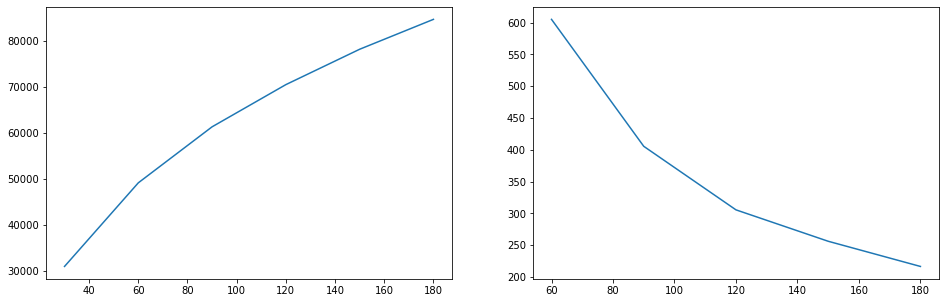

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
39177  33053057250000      30  31040.00       nan        nan        nan
39178  33053057250000      60  49199.00     30.00   18159.00     605.30
39179  33053057250000      90  61364.00     30.00   12165.00     405.50
39180  33053057250000     120  70528.00     30.00    9164.00     305.47
39181  33053057250000     150  78209.00     30.00    7681.00     256.03
39182  33053057250000     180  84701.00     30.00    6492.00     216.40
39183  33053057250000     270       nan     90.00        nan        nan
39184  33053057250000     365       nan     95.00        nan        nan
39185  33053057250000     730       nan    365.00        nan        nan

In [126]:
well_oi = well_ids[700]
plot_well_curve(prod_df, well_oi)

### Here is an abnormal-looking production curve:
This is something that could be cleaned up to improve model accuracy.

## 33061011120000

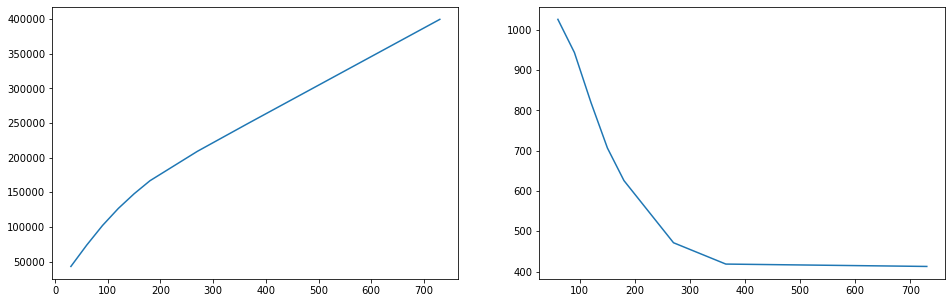

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
44487  33061011120000      30  42971.00       nan        nan        nan
44488  33061011120000      60  73754.00     30.00   30783.00    1026.10
44489  33061011120000      90 102068.00     30.00   28314.00     943.80
44490  33061011120000     120 126670.00     30.00   24602.00     820.07
44491  33061011120000     150 147869.00     30.00   21199.00     706.63
44492  33061011120000     180 166646.00     30.00   18777.00     625.90
44493  33061011120000     270 209089.00     90.00   42443.00     471.59
44494  33061011120000     365 248861.00     95.00   39772.00     418.65
44495  33061011120000     730 399518.00    365.00  150657.00     412.76

In [127]:
well_oi = well_ids[500]
plot_well_curve(prod_df, well_oi)

<a name="paragraph7"></a>
# Preliminary model fitting

In [128]:
def normalize_formation(x):
    if x in {"bakken", "three forks"}:
        return x
    else:
        return np.nan

In [129]:
def normalize_formation_helper(df, primary_col, secondary_col):
    df = df.copy()
    fill_values = df[secondary_col].str.lower().apply(lambda x: normalize_formation(x))
    df["target_formation"] = df[primary_col].apply(lambda x: normalize_formation(x)).fillna(fill_values)
    df = pd.get_dummies(data=df, columns=["target_formation"], prefix="formation")
    df.drop([primary_col, secondary_col], axis=1, inplace=True)
    return df

In [130]:
target = "production_liquid_180"

In [131]:
def fill_median(df, cols=None):
    df = df.copy()
    
    if cols == None:
        cols = df.columns
    for col in cols:
        fill_value = df[col].median()
        df[col].fillna(value=fill_value, inplace=True)
        
    return df

In [132]:
model_features = summary_df.query("using == True").index.tolist()

In [133]:
full_df = (inspect_df.copy()
               .dropna(subset=[target])
               .pipe(normalize_formation_helper, "stimulated_formation", "producedpools")
               .assign(choke_size=lambda x: x["choke_size"].apply(lambda x: dmt.parse_choke_size(x)))
               .filter(model_features + [target_col])
               .pipe(fill_median) 
          )

In [134]:
test, train = train_test_split(full_df)
train_X, train_y = mft.X_y_split(test, target=target)
test_X, test_y = mft.X_y_split(test, target=target)

In [135]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=500, 
                                subsample = .7, 
                                max_depth =7, 
                                min_samples_split= 3, 
                                random_state=1984)

In [136]:
gbr.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=1984, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Error metrics

In [137]:
 mse, mae, rmse, rrse = mft.eval_model(gbr, test_X, test_y, train_y)

y_hat = gbr.predict(test_X)

eval_df = (pd.concat([test_y.reset_index(), pd.Series(y_hat, name="pred").round(2)], axis=1)
           .set_index("api")
           .rename(columns={"production_liquid_180": "actual"})
           .assign(resid=lambda x: x["pred"] - x["actual"])
           .assign(perc_resid=lambda x: x["resid"] / x["actual"] * 100)
           .assign(abs_resid=lambda x: x["resid"].abs())
           .assign(abs_perc_resid=lambda x: x["abs_resid"] / x["actual"] * 100)
          )

mape = eval_df.abs_perc_resid.mean()

mape_adj = eval_df.abs_resid.mean() / eval_df.actual.mean() * 100

In [138]:
error_dict = {"mae ": mae, "rmse": rmse, "rrse": rrse, "mae": mae, "mape": mape, "adj_mape": mape_adj}

In [139]:
for name, val in error_dict.items():
    print(name, val.round())

mae  13530.0
rmse 17748.0
rrse 54.0
mae 13530.0
mape 33.0
adj_mape 22.0


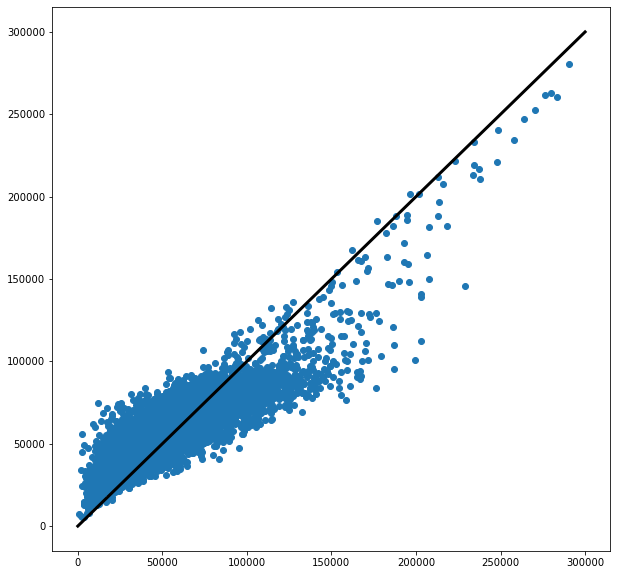

In [193]:
plt.subplots(figsize=(10, 10))
plt.scatter(data=eval_df, x="actual", y="pred")
plt.plot([0, 300000], [0, 300000], c="k", linewidth=3)

### The model is clearly biased: it's overpredicting small values and underpredicting large values

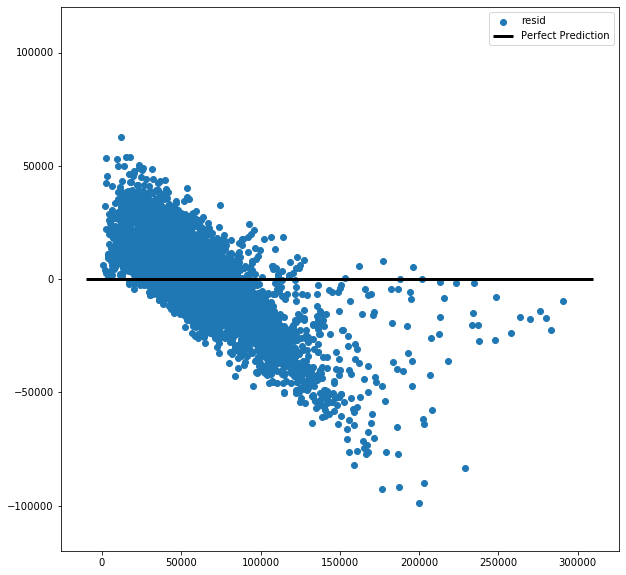

In [196]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(data=eval_df, x="actual", y="resid")
ax.set_ylim(-120000, 120000)
ax.hlines(y=0, xmin=-10000, xmax=310000, label="Perfect Prediction", linewidth=3)
plt.legend()

In [142]:
feat_imp_df = mft.get_rig_df(gbr, train_X.columns.values)

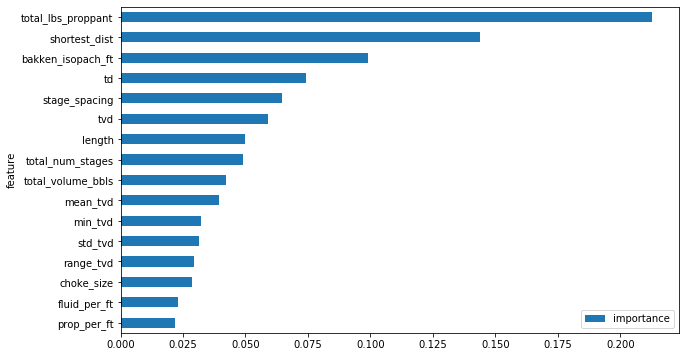

In [143]:
# This all makes sense
feat_imp_df.plot.barh(figsize=(10, 6))

### TODO:
- [X] Table of Contents, 
- [ ] Narrative
- [ ] Drop rows with multiple missing values, esply lat/lon
- [ ] Import formation tops, recaluclate target formation
- [ ] Detect anomalies and impute production for young wells
